In [ ]:
pip install -U scikit-learn xgboost pandas numpy matplotlib


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('test.csv')


print("Dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (418, 11)

Missing values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

First few rows:
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0   

In [8]:

def preprocess_data(df):

    df_processed = df.copy()

    df_processed['Survived'] = 0


    df_processed.loc[(df_processed['Sex'] == 'female') & (df_processed['Age'] < 18), 'Survived'] = 1
    df_processed.loc[(df_processed['Sex'] == 'female') & (df_processed['Pclass'] == 1), 'Survived'] = 1
    df_processed.loc[(df_processed['Sex'] == 'female') & (df_processed['Pclass'] == 2), 'Survived'] = 1

    df_processed.loc[(df_processed['Sex'] == 'male') & (df_processed['Pclass'] == 1) &
                    (df_processed['Age'] < 16), 'Survived'] = 1

    np.random.seed(42)
    random_survival = np.random.choice([0, 1], size=len(df_processed), p=[0.7, 0.3])
    df_processed['Survived'] = np.where(df_processed['Survived'] == 1, 1, random_survival)


    df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df_processed['Title'] = df_processed['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',
                                                          'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df_processed['Title'] = df_processed['Title'].replace('Mlle', 'Miss')
    df_processed['Title'] = df_processed['Title'].replace('Ms', 'Miss')
    df_processed['Title'] = df_processed['Title'].replace('Mme', 'Mrs')


    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1

    df_processed['IsAlone'] = 0
    df_processed.loc[df_processed['FamilySize'] == 1, 'IsAlone'] = 1

    df_processed['AgeBand'] = pd.cut(df_processed['Age'], 5)


    df_processed['FarePerPerson'] = df_processed['Fare'] / df_processed['FamilySize']
    df_processed['FarePerPerson'] = df_processed['FarePerPerson'].fillna(0)


    df_processed['HasCabin'] = df_processed['Cabin'].notnull().astype(int)


    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
                'IsAlone', 'HasCabin', 'Title', 'FarePerPerson']

    X = df_processed[features]
    y = df_processed['Survived']


    le = LabelEncoder()
    X['Sex'] = le.fit_transform(X['Sex'])
    X['Title'] = le.fit_transform(X['Title'].astype(str))


    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


    scaler = StandardScaler()
    numerical_cols = ['Age', 'Fare', 'FamilySize', 'FarePerPerson']
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    return X, y


X, y = preprocess_data(df)


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 250 samples
Validation set: 84 samples
Test set: 84 samples


In [11]:

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}


results = []

for name, model in models.items():
    print(f"\nTraining {name}...")


    model.fit(X_train, y_train)


    y_pred = model.predict(X_val)


    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    cm = confusion_matrix(y_val, y_pred)


    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': cm
    })

    print(f"{name} - Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1: {f1:.5f}")


results_df = pd.DataFrame(results)
comparison_table = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].copy()


comparison_table['Accuracy'] = comparison_table['Accuracy'].round(3)
comparison_table['Precision'] = comparison_table['Precision'].round(3)
comparison_table['Recall'] = comparison_table['Recall'].round(3)
comparison_table['F1-Score'] = comparison_table['F1-Score'].round(3)

print("\n" + "="*60)
print("MODEL COMPARISON TABLE")
print("="*60)
print(comparison_table.to_string(index=False))
print("="*60)


print("\nCONFUSION MATRICES:")
print("="*40)
for result in results:
    print(f"\n{result['Model']}:")
    print(result['Confusion Matrix'])


Training Logistic Regression...
Logistic Regression - Accuracy: 0.63095, Precision: 0.58974, Recall: 0.60526, F1: 0.59740

Training Decision Tree...
Decision Tree - Accuracy: 0.60714, Precision: 0.57576, Recall: 0.50000, F1: 0.53521

Training Random Forest...
Random Forest - Accuracy: 0.61905, Precision: 0.58824, Recall: 0.52632, F1: 0.55556

Training XGBoost...
XGBoost - Accuracy: 0.60714, Precision: 0.56098, Recall: 0.60526, F1: 0.58228

MODEL COMPARISON TABLE
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression     0.631      0.590   0.605     0.597
      Decision Tree     0.607      0.576   0.500     0.535
      Random Forest     0.619      0.588   0.526     0.556
            XGBoost     0.607      0.561   0.605     0.582

CONFUSION MATRICES:

Logistic Regression:
[[30 16]
 [15 23]]

Decision Tree:
[[32 14]
 [19 19]]

Random Forest:
[[32 14]
 [18 20]]

XGBoost:
[[28 18]
 [15 23]]


In [10]:

best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name}")


y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_cm = confusion_matrix(y_test, y_test_pred)

print(f"\nTest Set Performance ({best_model_name}):")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print("Confusion Matrix:")
print(test_cm)


Best model: Logistic Regression

Test Set Performance (Logistic Regression):
Accuracy:  0.7262
Precision: 0.7027
Recall:    0.6842
F1-Score:  0.6933
Confusion Matrix:
[[35 11]
 [12 26]]


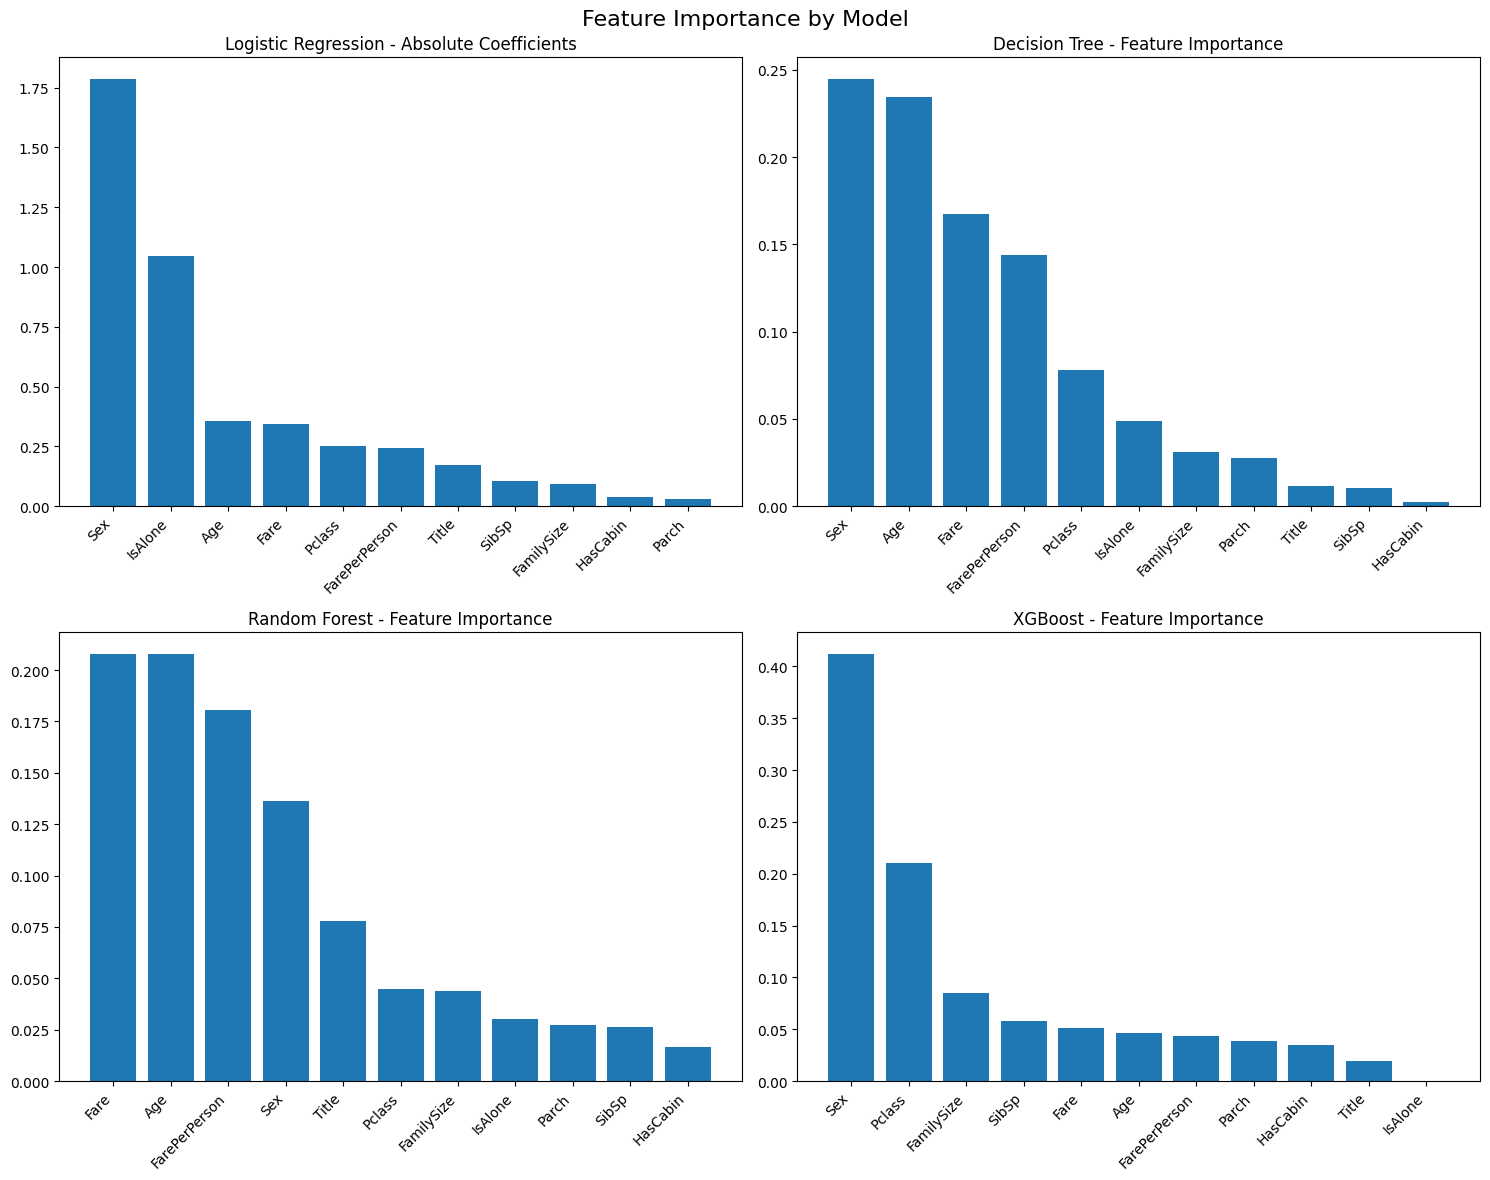

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Feature Importance by Model', fontsize=16)

for i, (name, model) in enumerate(models.items()):
    if hasattr(model, 'feature_importances_'):
        row, col = i // 2, i % 2
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        ax = axes[row, col]
        ax.bar(range(len(importances)), importances[indices])
        ax.set_title(f'{name} - Feature Importance')
        ax.set_xticks(range(len(importances)))
        ax.set_xticklabels([X.columns[i] for i in indices], rotation=45, ha='right')

    elif name == 'Logistic Regression':
        row, col = i // 2, i % 2
        coefficients = np.abs(model.coef_[0])
        indices = np.argsort(coefficients)[::-1]

        ax = axes[row, col]
        ax.bar(range(len(coefficients)), coefficients[indices])
        ax.set_title(f'{name} - Absolute Coefficients')
        ax.set_xticks(range(len(coefficients)))
        ax.set_xticklabels([X.columns[i] for i in indices], rotation=45, ha='right')

plt.tight_layout()
plt.show()